In [1]:
!pip install sqlalchemy
!pip install pyodbc

In [2]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd

In [3]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver+ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [4]:
engine = new_engine('mssql', 'DESKTOP-IE4OC6O', 'AdventureWorks2022', integrated_security=True)

mssql://DESKTOP-IE4OC6O/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [5]:
connection = engine.connect()

In [6]:
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [7]:
inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


In [8]:
for schema in schemas:
    print(schema)

db_accessadmin
db_backupoperator
db_datareader
db_datawriter
db_ddladmin
db_denydatareader
db_denydatawriter
db_owner
db_securityadmin
dbo
guest
HumanResources
INFORMATION_SCHEMA
Person
Production
Purchasing
Sales
sys


In [9]:
print(inspector.get_table_names(schema='Sales'))

['CountryRegionCurrency', 'CreditCard', 'Currency', 'CurrencyRate', 'Customer', 'PersonCreditCard', 'SalesOrderDetail', 'SalesOrderHeader', 'SalesOrderHeaderSalesReason', 'SalesPerson', 'SalesPersonQuotaHistory', 'SalesReason', 'SalesTaxRate', 'SalesTerritory', 'SalesTerritoryHistory', 'ShoppingCartItem', 'SpecialOffer', 'SpecialOfferProduct', 'Store']


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [123]:
# EMPLOYEE

# Overview for all employees, gender, vacation/sickleave and salary 

# Which gender is overrepresenting? 
# Is it any connection between gender, amount days of vacation/sickleave?
# How about salary for each gender? 

# Answers to these questions can be found further down in my queries. 

all_empoyees = pd.read_sql(sql="""SELECT HRE.BusinessEntityID
      ,HRE.JobTitle
      ,HRE.Gender
	  ,PP.FirstName
	  ,PP.LastName
	  ,HRE.VacationHours
	  ,HRE.SickLeaveHours
	  ,CASE WHEN VacationHours > SickLeaveHours THEN 'Vacation' 
	        WHEN VacationHours = SickLeaveHours THEN 'Equal'
      ELSE 'Sick' END AS Overrepresenting
	  ,SUM(HREPH.Rate) AS Salary
	  ,SSP.Bonus
	  ,SSP.CommissionPct
	  --fixa till så att null värde inte ställer till,(HREPH.Rate + SSP.Bonus) AS 'TotalSalary'
FROM HumanResources.Employee AS HRE
    JOIN Person.Person AS PP
    ON HRE.BusinessEntityID = PP.BusinessEntityID
	LEFT JOIN Sales.SalesPerson AS SSP
    ON HRE.BusinessEntityID = SSP.BusinessEntityID
	LEFT JOIN HumanResources.EmployeePayHistory AS HREPH
	ON HREPH.BusinessEntityID = HRE.BusinessEntityID
GROUP BY HRE.BusinessEntityID,
      HRE.JobTitle,
      HRE.Gender,
	  PP.FirstName,
	  PP.LastName,
	  HRE.VacationHours,
	  HRE.SickLeaveHours,
	  SSP.Bonus,
	  SSP.CommissionPct""",con=connection)
all_empoyees.head()

,BusinessEntityID,JobTitle,Gender,FirstName,LastName,VacationHours,SickLeaveHours,Overrepresenting,Salary,Bonus,CommissionPct
0,1,Chief Executive Officer,M,Ken,Sánchez,99,69,Vacation,125.5000,NaN,NaN
1,2,Vice President of Engineering,F,Terri,Duffy,1,20,Sick,63.4615,NaN,NaN
2,3,Engineering Manager,M,Roberto,Tamburello,2,21,Sick,43.2692,NaN,NaN
3,4,Senior Tool Designer,M,Rob,Walters,48,80,Sick,62.1862,NaN,NaN
4,5,Design Engineer,F,Gail,Erickson,5,22,Sick,32.6923,NaN,NaN


In [51]:
# Total amount emploees by gender

gender_employee = pd.read_sql(sql="""SELECT 
      Gender
	 ,COUNT(*) AS Total
FROM HumanResources.Employee
GROUP BY Gender""",con=connection)
gender_employee.head()

,Gender,Total
0,F,84
1,M,206


<BarContainer object of 2 artists>

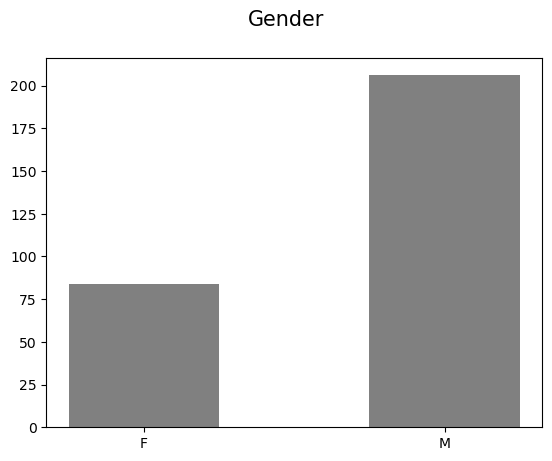

In [122]:
x=gender_employee.Gender
y=gender_employee.Total

fig, axs = plt.subplots()
fig.suptitle('Gender', size = 15)

axs.bar(x, y, color='grey', width=0.5)

In [195]:
# Amount of employees by department and gender

all_empoyees_by_department = pd.read_sql(sql="""SELECT HRD.Name AS Department,
       COUNT(*) AS Total_In_Department,
       COUNT(CASE WHEN HRE.Gender = 'F' THEN 1 END) AS Female,
       COUNT(CASE WHEN HRE.Gender = 'M' THEN 1 END) AS Male
FROM HumanResources.Department AS HRD
JOIN HumanResources.EmployeeDepartmentHistory AS HREDH
  ON HRD.DepartmentID = HREDH.DepartmentID
JOIN HumanResources.Employee AS HRE
  ON HREDH.BusinessEntityID = HRE.BusinessEntityID
GROUP BY HRD.Name
ORDER BY Total_In_Department DESC""",con=connection)
all_empoyees_by_department.head(300)

,Department,Total_In_Department,Female,Male
0,Production,180,46,134
1,Sales,18,7,11
2,Purchasing,13,4,9
3,Finance,11,6,5
4,Information Services,10,4,6
5,Marketing,10,5,5
6,Engineering,7,3,4
7,Facilities and Maintenance,7,2,5
8,Quality Assurance,7,1,6
9,Production Control,6,0,6


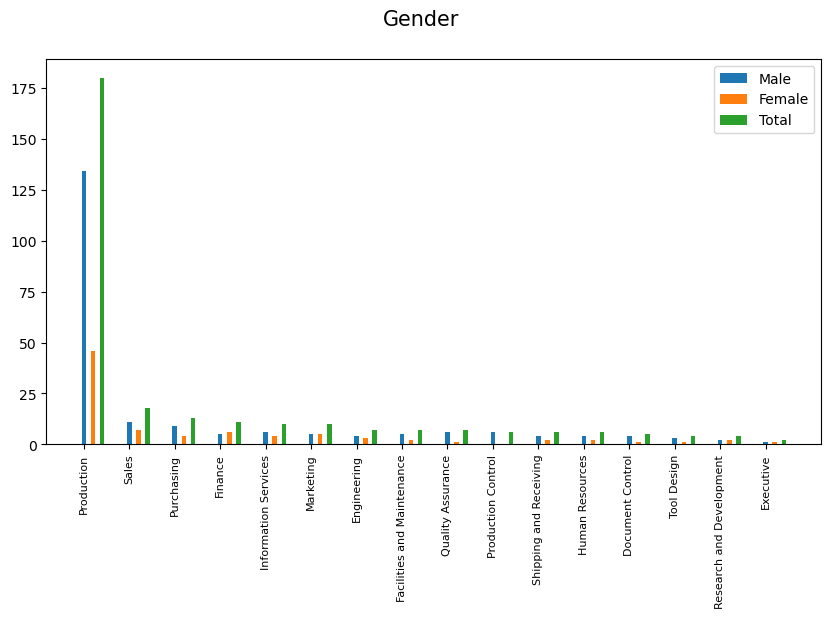

In [211]:
# Plotbar showing employees by department and gender

ymale=all_empoyees_by_department.Male
yfemale=all_empoyees_by_department.Female
ytotal=all_empoyees_by_department.Total_In_Department
x=all_empoyees_by_department.Department


xaxis = np.arange(len(x)) 
fig, axs = plt.subplots(figsize = (10, 5))
fig.suptitle('Gender', size = 15)

axs.bar(xaxis + 0.0, ymale,  0.1, label ='Male')
axs.bar(xaxis + 0.2, yfemale, 0.1, label ='Female') 
axs.bar(xaxis + 0.4, ytotal, 0.1, label ='Total')

axs.set_xticks(xaxis)
axs.set_xticklabels(all_empoyees_by_department.Department, rotation=90, fontsize=8)

axs.legend()


In [125]:
# Salary for each gender

salary = pd.read_sql(sql="""
SELECT HRE.Gender, 
    COUNT(*) AS Sum_of_each_gender,
	MIN (Rate) AS Min_Salary,
	MAX(Rate) AS Max_Salary,
	AVG(Rate) AS Avg_Salary,
	SUM(HREPH.Rate) AS Sum_of_Salary
FROM HumanResources.Employee AS HRE 
JOIN HumanResources.EmployeePayHistory AS HREPH
ON HRE.BusinessEntityID = HREPH.BusinessEntityID
WHERE HREPH.ModifiedDate=(
    SELECT MAX(ModifiedDate)
	FROM HumanResources.EmployeePayHistory)
GROUP BY HRE.Gender
""",con=connection)
salary.head()

,Gender,Sum_of_each_gender,Min_Salary,Max_Salary,Avg_Salary,Sum_of_Salary
0,F,82,9.0,63.4615,18.5992,1525.1362
1,M,195,9.0,125.5000,17.9487,3500.0158


In [17]:
# When we remove the chief (highest salary in a whole company) from salary statistics, the output becomes a bit different.

salary_exl_chef = pd.read_sql(sql="""
SELECT HRE.Gender,
    COUNT(*) AS Sum_of_each_gender,
	MIN (Rate) AS Min_Salary,
	MAX(Rate) AS Max_Salary,
	AVG(Rate) AS Avg_Salary,
	SUM(HREPH.Rate) AS Sum_of_Salary
FROM HumanResources.Employee AS HRE 
JOIN HumanResources.EmployeePayHistory AS HREPH
ON HRE.BusinessEntityID = HREPH.BusinessEntityID
WHERE HRE.BusinessEntityID NOT IN (1)
AND HREPH.ModifiedDate=(
    SELECT MAX(ModifiedDate)
	FROM HumanResources.EmployeePayHistory)
GROUP BY Gender
""",con=connection)
salary_exl_chef.head()

,Gender,Sum_of_each_gender,Min_Salary,Max_Salary,Avg_Salary,Sum_of_Salary
0,F,82,9.0,63.4615,18.5992,1525.1362
1,M,194,9.0,84.1346,17.3944,3374.5158


In [18]:
# Vacation or sickleave, what is overrepresenting for every gender?

ledighet_sjukfranvaro = pd.read_sql(sql="""
SELECT BusinessEntityID
   ,Gender
   ,VacationHours
   ,SickLeaveHours
   ,CASE WHEN VacationHours > SickLeaveHours THEN 'Vacation'
      ELSE 'Sick' END AS Overpresenting
FROM HumanResources.Employee 
GROUP BY BusinessEntityID, Gender, VacationHours, SickLeaveHours
""",con=connection)
ledighet_sjukfranvaro.head(300)

,BusinessEntityID,Gender,VacationHours,SickLeaveHours,Overpresenting
0,1,M,99,69,Vacation
1,2,F,1,20,Sick
2,3,M,2,21,Sick
3,4,M,48,80,Sick
4,5,F,5,22,Sick
...,...,...,...,...,...
285,286,F,36,38,Sick
286,287,F,21,30,Sick
287,288,F,35,37,Sick
288,289,F,37,38,Sick


In [19]:
# Vacation and seackleave by gender 

ledighet_sjukfranvaro_by_gender_total = pd.read_sql(sql="""
SELECT Gender,
      COUNT(*) AS Total,
      COUNT(CASE WHEN VacationHours > SickLeaveHours THEN 1 END) AS 'Vacation',
	  COUNT(CASE WHEN VacationHours < SickLeaveHours THEN 1 END) AS 'Sick',
      MIN (VacationHours) AS Min_VHours,
	  MAX(VacationHours) AS Max_VHours,
	  MIN (SickLeaveHours) AS Min_SLHours,
	  MAX(SickLeaveHours) AS Max_SLHours,
	  AVG(VacationHours) AS Avg_VHours,
	  AVG(SickLeaveHours) AS Avg_SLHours,
	  SUM(VacationHours) AS Sum_VHours,
	  SUM(SickLeaveHours) AS Sum_SLHours
FROM HumanResources.Employee 
GROUP BY Gender
""",con=connection)
ledighet_sjukfranvaro_by_gender_total.head()

,Gender,Total,Vacation,Sick,Min_VHours,Max_VHours,Min_SLHours,Max_SLHours,Avg_VHours,Avg_SLHours,Sum_VHours,Sum_SLHours
0,F,84,55,29,0,99,20,69,52,45,4375,3844
1,M,206,122,78,0,99,20,80,50,45,10303,9295


In [149]:
# Sales EMPLOYEES by gender, sales results 
# Development of sales - invrease or decrease compared to the year before
# Status of quota, have the sellers met their sale goals?

sales_employee = pd.read_sql(sql="""
SELECT HRE.BusinessEntityID AS B_ID
      ,HRE.JobTitle
      ,HRE.Gender
	  ,PP.FirstName AS F_Name
	  ,PP.LastName AS L_Name
	  ,HRE.BirthDate
	  ,HREPH.Rate AS Salary
	  ,SSP.Bonus
	  ,SSP.CommissionPct
	  ,SSP.SalesYTD
	  ,SSP.SalesLastYear
	  ,(SSP.SalesYTD + SSP.SalesLastYear) AS TotalSales
	  ,IIF(SSP.SalesYTD > SSP.SalesLastYear, 'Increase' , 'Decrease') AS 'GrowthOfSales'
	  ,CASE WHEN (SSP.SalesYTD - SSP.SalesQuota)> 0 THEN 'Success' WHEN SSP.SalesYTD IS NULL THEN 'NULL'
	  ELSE 'Failure' END AS StatusOfQuota
	  ,SSP.SalesQuota
FROM HumanResources.Employee AS HRE JOIN Sales.SalesPerson AS SSP
    ON HRE.BusinessEntityID = SSP.BusinessEntityID
	LEFT JOIN Person.Person AS PP
    ON HRE.BusinessEntityID = PP.BusinessEntityID
	LEFT JOIN HumanResources.EmployeePayHistory AS HREPH
	ON HREPH.BusinessEntityID = HRE.BusinessEntityID
--ORDER BY SalesYTD DESC
""",con=connection)
sales_employee.head()

,B_ID,JobTitle,Gender,F_Name,L_Name,BirthDate,Salary,Bonus,CommissionPct,SalesYTD,SalesLastYear,TotalSales,GrowthOfSales,StatusOfQuota,SalesQuota
0,274,North American Sales Manager,M,Stephen,Jiang,1951-10-17,48.1010,0.0,0.000,5.596976e+05,0.000000e+00,5.596976e+05,Increase,Failure,NaN
1,275,Sales Representative,M,Michael,Blythe,1968-12-25,23.0769,4100.0,0.012,3.763178e+06,1.750406e+06,5.513585e+06,Increase,Success,300000.0
2,276,Sales Representative,F,Linda,Mitchell,1980-02-27,23.0769,2000.0,0.015,4.251369e+06,1.439156e+06,5.690525e+06,Increase,Success,250000.0
3,277,Sales Representative,F,Jillian,Carson,1962-08-29,23.0769,2500.0,0.015,3.189418e+06,1.997186e+06,5.186605e+06,Increase,Success,250000.0
4,278,Sales Representative,M,Garrett,Vargas,1975-02-04,23.0769,500.0,0.010,1.453719e+06,1.620277e+06,3.073996e+06,Decrease,Success,250000.0


In [129]:
# Total amount of sales department emploees by gender

gender_sales_employee = pd.read_sql(sql="""
SELECT
       HRE.Gender
	   ,COUNT(*) AS Qty_Gender
FROM HumanResources.Employee AS HRE 
JOIN Sales.SalesPerson AS SSP
ON HRE.BusinessEntityID = SSP.BusinessEntityID
GROUP BY Gender
ORDER BY Qty_Gender DESC
""",con=connection)
gender_sales_employee.head()

,Gender,Qty_Gender
0,M,10
1,F,7


<BarContainer object of 2 artists>

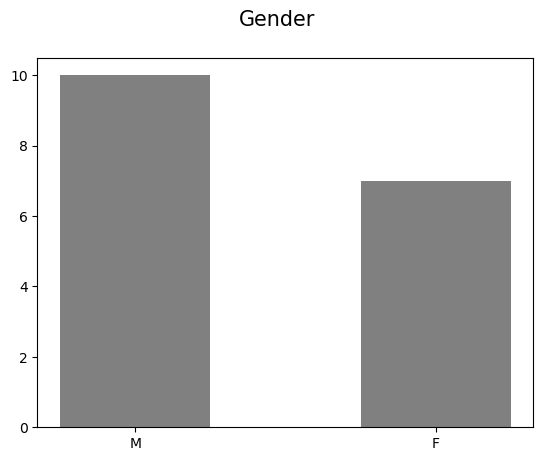

In [130]:
x=gender_sales_employee.Gender
y=gender_sales_employee.Qty_Gender

fig, axs = plt.subplots()
fig.suptitle('Gender', size = 15)

axs.bar(x, y, color='grey', width=0.5)

In [163]:
# Salary for sales emploees by gender
# Bonus

salary = pd.read_sql(sql="""
SELECT HRE.Gender, 
    COUNT(*) AS Sum_of_each_gender,
	MIN (Rate) AS Min_Salary,
	MAX(Rate) AS Max_Salary,
	AVG(Rate) AS Avg_Salary,
	SUM(HREPH.Rate) AS Sum_of_Salary,
    SUM(SSP.Bonus) AS Sum_Bonus,
    MIN(SSP.Bonus) AS Min_Bonus,
	MAX(SSP.Bonus) AS Max_Bonus,
    AVG(SSP.Bonus) AS Avg_Bonus
FROM HumanResources.Employee AS HRE
JOIN Sales.SalesPerson AS SSP
ON HRE.BusinessEntityID = SSP.BusinessEntityID
LEFT JOIN HumanResources.EmployeePayHistory AS HREPH
ON HRE.BusinessEntityID = HREPH.BusinessEntityID
WHERE HREPH.ModifiedDate=(
    SELECT MAX(ModifiedDate)
	FROM HumanResources.EmployeePayHistory)
GROUP BY HRE.Gender
""",con=connection)
salary.head()

,Gender,Sum_of_each_gender,Min_Salary,Max_Salary,Avg_Salary,Sum_of_Salary,Sum_Bonus,Min_Bonus,Max_Bonus,Avg_Bonus
0,F,7,23.0769,48.101,26.6517,186.5624,20375.0,0.0,5650.0,2910.7142
1,M,10,23.0769,48.101,28.0817,280.8172,28235.0,0.0,6700.0,2823.5000


In [217]:
# Calculation of confidens interval for the avarage salary 

salary = sales_employee.Salary
ci = st.norm.interval(0.95, loc=np.mean(salary), scale=st.sem(salary))

print(f"Confidence Interval for average salary: {ci}")

Confidence Interval for average salary: (22.818556210395826, 32.167279083721816)


In [146]:
#Vacation and seekleave sales employees

ledighet_sjukfranvaro_by_gender_sales = pd.read_sql(sql="""
SELECT Gender,
      COUNT(*) AS Total,
      COUNT(CASE WHEN VacationHours > SickLeaveHours THEN 1 END) AS 'Vacation',
	  COUNT(CASE WHEN VacationHours < SickLeaveHours THEN 1 END) AS 'Sick',
      MIN (VacationHours) AS Min_VHours,
	  MAX(VacationHours) AS Max_VHours,
	  MIN (SickLeaveHours) AS Min_SLHours,
	  MAX(SickLeaveHours) AS Max_SLHours,
	  AVG(VacationHours) AS Avg_VHours,
	  AVG(SickLeaveHours) AS Avg_SLHours,
	  SUM(VacationHours) AS Sum_VHours,
	  SUM(SickLeaveHours) AS Sum_SLHours
FROM HumanResources.Employee AS HRE
JOIN Sales.SalesPerson AS SSP
ON HRE.BusinessEntityID = SSP.BusinessEntityID
GROUP BY Gender
""",con=connection)
ledighet_sjukfranvaro_by_gender_sales.head()

,Gender,Total,Vacation,Sick,Min_VHours,Max_VHours,Min_SLHours,Max_SLHours,Avg_VHours,Avg_SLHours,Sum_VHours,Sum_SLHours
0,F,7,0,7,21,37,30,38,28,34,202,239
1,M,10,0,9,14,39,27,39,28,34,287,341


In [213]:
# Sales by gender (Sales employees)

sales_employee_sales = pd.read_sql(sql="""
SELECT HRE.Gender
	  ,SUM(SSP.SalesYTD) AS Sum_SalesYTD
      ,MIN(SSP.SalesYTD) AS Min_SalesYTD
	  ,MAX(SSP.SalesYTD) AS Max_SalesYTD
      ,AVG(SSP.SalesYTD) AS Avg_SalesYTD
	  ,SUM(SSP.SalesLastYear) AS Sum_SalesLastYear
      ,MIN(SSP.SalesLastYear) AS Min_SalesLastYear
	  ,MAX(SSP.SalesLastYear) AS Max_SalesLastYear
      ,AVG(SSP.SalesLastYear) AS Avg_SalesLastYear
	  ,SUM(SSP.SalesYTD + SSP.SalesLastYear) AS TotalSales
	  ,SUM(SSP.SalesQuota) AS Total_Sales_Q
FROM HumanResources.Employee AS HRE 
JOIN Sales.SalesPerson AS SSP
ON HRE.BusinessEntityID = SSP.BusinessEntityID
GROUP BY HRE.Gender
""",con=connection)
sales_employee_sales.head()


,Gender,Sum_SalesYTD,Min_SalesYTD,Max_SalesYTD,Avg_SalesYTD,Sum_SalesLastYear,Min_SalesLastYear,Max_SalesLastYear,Avg_SalesLastYear,TotalSales,Total_Sales_Q
0,F,1.667902e+07,519905.9320,4.251369e+06,2.382717e+06,1.058572e+07,0.0,2.278549e+06,1.512246e+06,2.726474e+07,1500000.0
1,M,1.959857e+07,172524.4512,3.763178e+06,1.959857e+06,1.310024e+07,0.0,2.396540e+06,1.310024e+06,3.269881e+07,2150000.0


In [167]:
# Historical sales made by each seller with profits

# Find total profit made by each seller
# Man går back på vissa artiklar. Lagt till kolumn DiffListUnit för att få fram det
# Ta reda på hur många ordrar gjordes månadsvis

total_profit_by_seller = pd.read_sql(sql="""
SELECT SSOD.ProductID
     , PRP.StandardCost
	 , SSOD.UnitPrice
	 , PRP.ListPrice
	 , (PRP.ListPrice - UnitPrice) AS DiffListUnit
	 , (SSOD.UnitPrice - PRP.StandardCost - SSOD.UnitPriceDiscount) AS UnitProfit
	 , SSOD.OrderQty
	 , SSOD.UnitPriceDiscount
	 , SSOD.LineTotal
	 , (SSOD.UnitPrice - PRP.StandardCost - SSOD.UnitPriceDiscount) * SSOD.OrderQty AS TotalLineProfit
	 , HRE.BusinessEntityID
	 , HRE.Gender
	 , HRE.JobTitle
	 , PP.FirstName
	 , PP.LastName
	 , SSOH.OrderDate
FROM Sales.SalesOrderDetail AS SSOD JOIN Sales.SalesOrderHeader AS SSOH
ON SSOD.SalesOrderID = SSOH.SalesOrderID
LEFT JOIN Sales.SalesPerson AS SSP
ON SSOH.TerritoryID = SSP.TerritoryID
LEFT JOIN HumanResources.Employee AS HRE
ON HRE.BusinessEntityID = SSP.BusinessEntityID
LEFT JOIN Person.Person AS PP
ON PP.BusinessEntityID = HRE.BusinessEntityID
LEFT JOIN Production.Product AS PRP
ON PRP.ProductID = SSOD.ProductID
ORDER BY SSOD.SalesOrderID DESC 
""",con=connection)
total_profit_by_seller.head()

,ProductID,StandardCost,UnitPrice,ListPrice,DiffListUnit,UnitProfit,OrderQty,UnitPriceDiscount,LineTotal,TotalLineProfit,BusinessEntityID,Gender,JobTitle,FirstName,LastName,OrderDate
0,879,59.4660,159.00,159.00,0.0,99.5340,1,0.0,159.00,99.5340,282,M,Sales Representative,José,Saraiva,2014-06-30
1,879,59.4660,159.00,159.00,0.0,99.5340,1,0.0,159.00,99.5340,278,M,Sales Representative,Garrett,Vargas,2014-06-30
2,878,8.2205,21.98,21.98,0.0,13.7595,1,0.0,21.98,13.7595,282,M,Sales Representative,José,Saraiva,2014-06-30
3,878,8.2205,21.98,21.98,0.0,13.7595,1,0.0,21.98,13.7595,278,M,Sales Representative,Garrett,Vargas,2014-06-30
4,712,6.9223,8.99,8.99,0.0,2.0677,1,0.0,8.99,2.0677,282,M,Sales Representative,José,Saraiva,2014-06-30


In [170]:
# Historical sales made by each seller with profits
# Some items are not profitable. DiffListUnit column catches them.


total_profit_by_gender = pd.read_sql(sql="""
SELECT HRE.Gender,
       SUM (PRP.StandardCost) AS Tot_Standard_Cost,
	   SUM (SSOD.UnitPrice) AS Tot_Unit_price,
	   SUM (PRP.ListPrice) AS Tot_List_price,
	   SUM (PRP.ListPrice - UnitPrice) AS Tot_Diff_List_Unit,
	   SUM (SSOD.UnitPrice - PRP.StandardCost - SSOD.UnitPriceDiscount) AS Tot_Unit_Profit,
	   SUM (SSOD.OrderQty) AS Tot_Order_Quant,
	   SUM (SSOD.UnitPriceDiscount) AS Tot_price_discount,
	   SUM (SSOD.LineTotal) AS Tot_Line,
	   SUM ((SSOD.UnitPrice - PRP.StandardCost - SSOD.UnitPriceDiscount) * SSOD.OrderQty) AS Tot_Quantity_Profit
FROM Sales.SalesOrderDetail AS SSOD JOIN Sales.SalesOrderHeader AS SSOH
ON SSOD.SalesOrderID = SSOH.SalesOrderID
LEFT JOIN Sales.SalesPerson AS SSP
ON SSOH.TerritoryID = SSP.TerritoryID
LEFT JOIN HumanResources.Employee AS HRE
ON HRE.BusinessEntityID = SSP.BusinessEntityID
LEFT JOIN Person.Person AS PP
ON PP.BusinessEntityID = HRE.BusinessEntityID
LEFT JOIN Production.Product AS PRP
ON PRP.ProductID = SSOD.ProductID
GROUP BY Gender
""",con=connection)
total_profit_by_gender.head()

,Gender,Tot_Standard_Cost,Tot_Unit_price,Tot_List_price,Tot_Diff_List_Unit,Tot_Unit_Profit,Tot_Order_Quant,Tot_price_discount,Tot_Line,Tot_Quantity_Profit
0,F,3.074053e+07,4.022859e+07,52076089.88,1.184749e+07,9.487846e+06,166909,215.95,7.142003e+07,8.831339e+06
1,M,4.261259e+07,4.997314e+07,72676737.90,2.270360e+07,7.360191e+06,290043,354.95,1.111366e+08,6.154783e+06


In [ ]:
# Avarage sale, profit for each gender

In [214]:
total_profit_by_gender_avg = pd.read_sql(sql="""
SELECT HRE.Gender,
       AVG (PRP.StandardCost) AS Avg_Standard_Cost,
	   AVG (SSOD.UnitPrice) AS Avg_Unit_price,
	  -- SUM (PRP.ListPrice) AS Tot_List_price,
	  -- SUM (PRP.ListPrice - UnitPrice) AS Tot_Diff_List_Unit,
	   AVG (SSOD.UnitPrice - PRP.StandardCost - SSOD.UnitPriceDiscount) AS Avg_Unit_Profit,
	   AVG (SSOD.OrderQty) AS Avg_Order_Quant,
	   AVG (SSOD.UnitPriceDiscount) AS Avg_price_discount,
	   AVG (SSOD.LineTotal) AS Avg_Line,
	   AVG ((SSOD.UnitPrice - PRP.StandardCost - SSOD.UnitPriceDiscount) * SSOD.OrderQty) AS Avg_Quantity_Profit
FROM Sales.SalesOrderDetail AS SSOD JOIN Sales.SalesOrderHeader AS SSOH
ON SSOD.SalesOrderID = SSOH.SalesOrderID
LEFT JOIN Sales.SalesPerson AS SSP
ON SSOH.TerritoryID = SSP.TerritoryID
LEFT JOIN HumanResources.Employee AS HRE
ON HRE.BusinessEntityID = SSP.BusinessEntityID
LEFT JOIN Person.Person AS PP
ON PP.BusinessEntityID = HRE.BusinessEntityID
LEFT JOIN Production.Product AS PRP
ON PRP.ProductID = SSOD.ProductID
GROUP BY Gender
""",con=connection)
total_profit_by_gender_avg.head()

,Gender,Avg_Standard_Cost,Avg_Unit_price,Avg_Unit_Profit,Avg_Order_Quant,Avg_price_discount,Avg_Line,Avg_Quantity_Profit
0,F,377.8659,494.4943,116.6256,2,0.0026,877.902790,108.5557
1,M,359.8975,422.0632,62.1627,2,0.0029,938.638036,51.9820


In [28]:
# Profit for each product (production)

product_profit = pd.read_sql(sql="""
SELECT ProductID
     , Name
	 , ProductNumber
	 , Color
	 , ReorderPoint
	 , StandardCost
	 , ListPrice
	 , (ListPrice - StandardCost) AS Profit
	 , ((ListPrice - StandardCost)/ListPrice) AS ProfitPercent
	 , DaysToManufacture
	 , ProductModelID
	 , SellStartDate
FROM Production.Product
WHERE NOT ListPrice = 0.00
""",con=connection)
product_profit.head()

,ProductID,Name,ProductNumber,Color,ReorderPoint,StandardCost,ListPrice,Profit,ProfitPercent,DaysToManufacture,ProductModelID,SellStartDate
0,514,LL Mountain Seat Assembly,SA-M198,None,375,98.77,133.34,34.57,0.2592,1,NaN,2008-04-30
1,515,ML Mountain Seat Assembly,SA-M237,None,375,108.99,147.14,38.15,0.2592,1,NaN,2008-04-30
2,516,HL Mountain Seat Assembly,SA-M687,None,375,145.87,196.92,51.05,0.2592,1,NaN,2008-04-30
3,517,LL Road Seat Assembly,SA-R127,None,375,98.77,133.34,34.57,0.2592,1,NaN,2008-04-30
4,518,ML Road Seat Assembly,SA-R430,None,375,108.99,147.14,38.15,0.2592,1,NaN,2008-04-30


In [30]:
# Sales by product

sales_by_product = pd.read_sql(sql="""
SELECT SalesOrderDetail.ProductID
    , Product.Name
	, SUM (SalesOrderDetail.OrderQty) AS TotalQtySold
FROM Sales.SalesOrderDetail
     JOIN Production.Product
	 ON Sales.SalesOrderDetail.ProductID = Production.Product.ProductID
GROUP BY SalesOrderDetail.ProductID, Product.Name
ORDER BY TotalQtySold DESC
""",con=connection)
sales_by_product.head()

,ProductID,Name,TotalQtySold
0,712,AWC Logo Cap,8311
1,870,Water Bottle - 30 oz.,6815
2,711,"Sport-100 Helmet, Blue",6743
3,715,"Long-Sleeve Logo Jersey, L",6592
4,708,"Sport-100 Helmet, Black",6532


In [29]:
# Sales by order

orders = pd.read_sql(sql="""
SELECT ProductId
    , SalesOrderID
    , SUM(LineTotal) AS OrderTotal
	, SUM(OrderQty) AS NumberOfItems
	, COUNT (DISTINCT ProductID) AS UniqueItems
FROM Sales.SalesOrderDetail
GROUP BY ProductId, SalesOrderID
ORDER BY OrderTotal DESC
""",con=connection)
orders.head()

,ProductId,SalesOrderID,OrderTotal,NumberOfItems,UniqueItems
0,954,55282,27893.619000,26,1
1,772,43884,27055.760424,14,1
2,969,51131,26159.208075,21,1
3,775,43875,24938.476108,13,1
4,966,57054,23667.854925,19,1
